## Hamiltonian Monte-Carlo for the Precise Learner and Horseshoe Prior

Author: Clara Hoffmann \
HMC (see f.e. 'MCMC using Hamiltonian dynamics' by Neal, 2011) to obtain the posterior
of the coefficients of the last hidden layer and the copula parameters

Overview:
1. Initialize Variables
2. Run HMC chain

Note that the CIL versions for HMC are especially time-consuming. Derivatives based on Klein, Nott \& Smith 'Marginally Calibrated Deep Distributional Regression' (2020).

In [1]:
import numpy as np
from random import random
from tqdm import tqdm
import ray
import matplotlib.pyplot as plt
from helpers_horseshoe import generate_S2_S, log_density, Leapfrog, Delta_theta
import time
ray.init()

2021-08-11 12:23:40,252	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.140.16',
 'raylet_ip_address': '192.168.140.16',
 'redis_address': '192.168.140.16:24209',
 'object_store_address': '/tmp/ray/session_2021-08-11_12-23-39_592428_161306/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-11_12-23-39_592428_161306/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-08-11_12-23-39_592428_161306',
 'metrics_export_port': 53981,
 'node_id': '5330b328e1dd82eeb5e9c2c2469c1f9fddf5328060ef97ad41d886c3'}

## 1. Initialize Variables

In [2]:
# import data from DNN training
extracted_coefficients_directory = '../../data/commaai/extracted_coefficients/copula_cpl/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

In [3]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 25000 + 2
L = 77

# number of parameters of theta
q = 2*B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.zeros(q)

# stepsize
epsilon = 0.00007

r_m = np.append(np.zeros(p), np.append(np.repeat(-6,p), 0))

tau_start = theta_m_1[q-1]

In [4]:
Lambda = np.repeat(1,p)
BoB = B_zeta**2

## 2. Run Chain

In [ ]:
start = time.time()
seed = 6835963
r0 = np.repeat(None, 30000)
theta_tilde = np.repeat(None, 30000)
r_tilde = np.repeat(None, 30000)
log_dens = np.repeat(None, 30000)
r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, 30000)
alpha = np.repeat(None, 30000)
theta_m_1 = np.repeat(None, M)
r_m = np.repeat(None, M)
theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))

acc = []
# loop over number of samples that we want to produce
theta_tilde[0] = np.zeros(21)
r_tilde[0] = np.zeros(21)
theta_m_1[1] =  np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
all_thetas = []
theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
r_m[0] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
r_m[1] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
for m in tqdm(range(1, M)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = np.array(theta_m_1[m]).reshape(q,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], 
                                              r_tilde[m], 
                                              epsilon, n, z, p, 
                                              B_zeta, tBB, 
                                              betaBt, i, L, B_zeta, BoB)
        
    # compute gradient with theta
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    S2, S =  generate_S2_S(np.exp(0.5*theta_tilde[m][p:2*p]), BoB)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    theta_m_1[m] = np.array(theta_m_1[m])
    log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    proposed_u = log_density(S, B_zeta, theta_m_1[m][0:p], np.exp(0.5*theta_m_1[m][p:2*p]), theta_m_1[m][p], z, p)
    current_K = r_tilde[m].dot(r_tilde[m].T)*0.5
    proposed_K = r_m[m].dot(r_m[m].T)*0.5
    p_accept = log_dens[m] -  proposed_u + current_K - proposed_K
    alpha[m] = np.exp(min([np.log(1), p_accept]))
    
    # accept/reject
    if np.random.randn() <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    if (m % 1000 == 0) & (m > 1): 
        print('acceptance rate over last 1000 iterations: ' + str(np.mean(acc[-100:])))
end = time.time()
print(end - start)

  4%|▍         | 1000/25001 [2:13:00<52:23:29,  7.86s/it]

acceptance rate over last 1000 iterations: 0.55


  8%|▊         | 2000/25001 [4:25:59<52:26:52,  8.21s/it]

acceptance rate over last 1000 iterations: 0.68


 12%|█▏        | 3000/25001 [6:36:46<48:07:13,  7.87s/it]

acceptance rate over last 1000 iterations: 0.57


 16%|█▌        | 4000/25001 [8:48:47<43:58:15,  7.54s/it]

acceptance rate over last 1000 iterations: 0.71


 20%|█▉        | 5000/25001 [11:02:49<44:04:43,  7.93s/it]

acceptance rate over last 1000 iterations: 0.61


 23%|██▎       | 5741/25001 [12:39:30<40:36:31,  7.59s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 7000/25001 [15:18:10<37:45:48,  7.55s/it]

acceptance rate over last 1000 iterations: 0.68


 32%|███▏      | 8000/25001 [17:39:18<46:28:34,  9.84s/it]

acceptance rate over last 1000 iterations: 0.56


 36%|███▌      | 9000/25001 [20:14:09<42:15:51,  9.51s/it]

acceptance rate over last 1000 iterations: 0.73


 40%|███▉      | 10000/25001 [22:17:32<30:38:17,  7.35s/it]

acceptance rate over last 1000 iterations: 0.67


 41%|████      | 10205/25001 [22:42:24<29:47:08,  7.25s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 10539/25001 [23:22:38<27:34:18,  6.86s/it]

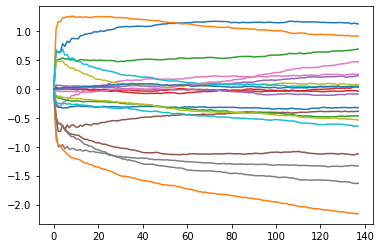

In [6]:
plt.plot(all_thetas)

In [ ]:
np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_new.npy', np.array(all_thetas))